# Imports and data loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
sns.set(style="ticks", color_codes=True)

In [2]:
data = pd.read_csv('../DATA/processed/dataset.csv', parse_dates=['date'])
data = data.set_index('date')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 86977 entries, 2019-04-01 00:00:00 to 2020-01-28 00:00:00
Data columns (total 14 columns):
P1                86108 non-null float64
P2                86109 non-null float64
pressure          86098 non-null float64
temperature       86098 non-null float64
humidity          86098 non-null float64
temp_meteo        86941 non-null float64
pres_meteo        86941 non-null float64
hum_meteo         86941 non-null float64
wind_direction    86941 non-null object
wind_speed        86941 non-null float64
precipitation     20196 non-null object
prec_amount       43164 non-null object
visibility        86833 non-null float64
dew_point_temp    86941 non-null float64
dtypes: float64(11), object(3)
memory usage: 10.0+ MB


# Preprocessing

Кодируем направление ветра через угол

In [4]:
wind_dir = {'Ветер, дующий с востока': 0,
            'Ветер, дующий с востоко-северо-востока': 45/2,
            'Ветер, дующий с северо-востока': 45,
            'Ветер, дующий с северо-северо-востока': 45 + 45/2,
            'Ветер, дующий с севера': 90,
            'Ветер, дующий с северо-северо-запад': 90 + 45/2,
            'Ветер, дующий с северо-запада': 135,
            'Ветер, дующий с западо-северо-запада': 135 + 45/2,
            'Ветер, дующий с запада': 180,
            'Ветер, дующий с западо-юго-запада': 180+45/2,
            'Ветер, дующий с юго-запада': 225,
            'Ветер, дующий с юго-юго-запада': 225 + 45/2,
            'Ветер, дующий с юга': 270,
            'Ветер, дующий с юго-юго-востока': 270 + 45/2,
            'Ветер, дующий с юго-востока': 315,
            'Ветер, дующий с востоко-юго-востока': 315 + 45/2,
            'Штиль, безветрие': None,
           }

In [5]:
data['wind_direction'] = data.wind_direction.fillna(method='bfill')
data['wind_direction'] = data.wind_direction.map(wind_dir)


кодируем тип осадков и количество

In [6]:
data['precipitation'] = data.precipitation.fillna(method='bfill')
data['prec_amount'] = data.prec_amount.fillna(method='bfill')
# data['precipitation'] = data.precipitation.fillna(value=0)
# data['prec_amount'] = data.prec_amount.fillna(value=0)

In [7]:
prec_codes = {0:0,
              'Облака покрывали половину неба или менее в течение всего соответствующего периода': 1,
              'Облака покрывали более половины неба в течение одной части соответствующего периода и' 
              'половину или менее в течение другой части периода.': 1,
              'Облака покрывали более половины неба в течение всего соответствующего периода.': 1,
              'Снег и/или другие виды твердых осадков': 2,
              'Морось.': 2,
              'Дождь со снегом или другими видами твердых осадков': 2,
              'Гроза (грозы) с осадками или без них.': 3,
              'Ливень (ливни).': 3,
              'Дождь.': 3,  
             }
data['precipitation'] = data.precipitation.map(prec_codes)

In [8]:
data['is_cloud'] = (data.precipitation == 1).astype(int)
data['is_snow'] = (data.precipitation == 2).astype(int)
data['is_rain'] = (data.precipitation == 3).astype(int)

In [9]:
data.loc[data.prec_amount == 'Осадков нет', 'prec_amount'] = 0
data.loc[data.prec_amount == 'Следы осадков', 'prec_amount'] = 0
data['prec_amount'] = data.prec_amount.astype(float)

In [10]:
data['dew_point_diff'] = data.temperature - data.dew_point_temp

Заполняем отсутствующие значения

In [11]:
data['P1'] = data.P1.interpolate()
data['P2'] = data.P2.interpolate()
data['pressure'] = data.pressure.interpolate()
data['temperature'] = data.temperature.interpolate()
data['humidity'] = data.humidity.interpolate()

Провереям, в каких столбцах есть None

In [12]:
for c in data.columns:
    if data[c].isnull().values.any():
        print(c)

temp_meteo
pres_meteo
hum_meteo
wind_direction
wind_speed
precipitation
prec_amount
visibility
dew_point_temp
dew_point_diff


# Anomaly detection
Разбиваем датефрейм на части по 7 дней, для каждой части делаем декомпозицию и смотрим на residual. Там, где выходит за 85-ый квантиль, считаем что есть аномалия.

In [13]:
weeks = [g for n, g in data.groupby(pd.Grouper(freq='7D'))]

In [14]:
anom_list = []
for w in weeks[:-2]:
    w['P1'] = w.P1.interpolate()
    w['P1'] = w.P1.rolling(4, min_periods=1).mean()
    freq = round(60*25/5) # 1 day
    decomp = sm.tsa.seasonal_decompose(w.P1, model='additive', freq=freq, extrapolate_trend='freq')
    q = decomp.resid.quantile(0.85)
    idx = decomp.resid[abs(decomp.resid)>q].index
    w['trend'] = decomp.trend
    w['seasonal'] = decomp.seasonal
    w['resid'] = decomp.resid
    w['anomaly'] = abs(w.resid)>q
    anomaly = w[w['anomaly']]
    anomaly['gap'] = (anomaly.index.to_series().diff()) > pd.Timedelta(10, 'm')
    l_mod = pd.to_datetime(anomaly[anomaly.gap].index)
    l_mod = l_mod.insert(0, anomaly.index[0])
    l_mod = l_mod.insert(len(l_mod), anomaly.index[-1])
    l = [anomaly[l_mod[n]:l_mod[n+1]] for n in range(0, len(l_mod)-1, 1)]
    l = [i[:-1] for i in l]
    l = [i for i in l if len(i) > 12]
    anom_list = anom_list + l

/home/anatoly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


посмотрим, что получилось

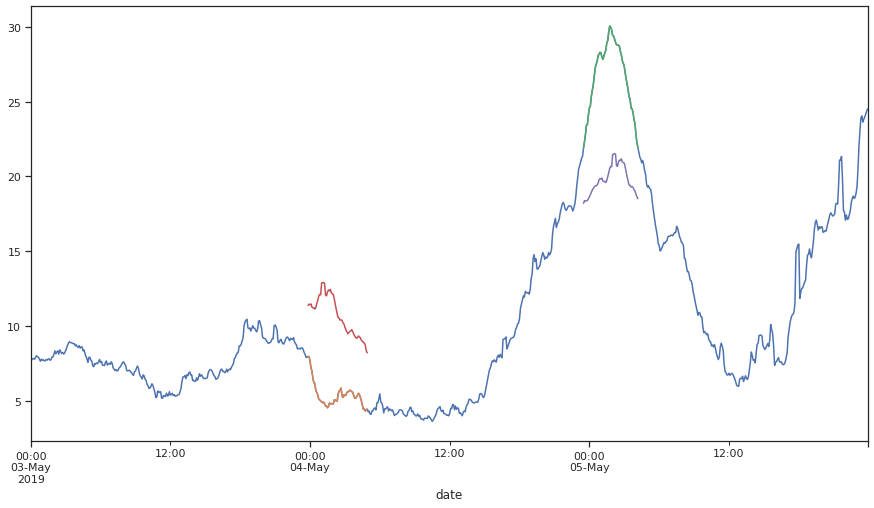

In [15]:
plt.figure(figsize=(15,8))
data['2019-05-3':'2019-05-5'].P1.plot()
anom_list[67].P1.plot()
anom_list[69].P1.plot()
(anom_list[67].trend+anom_list[67].seasonal).plot()
(anom_list[69].trend+anom_list[69].seasonal).plot()

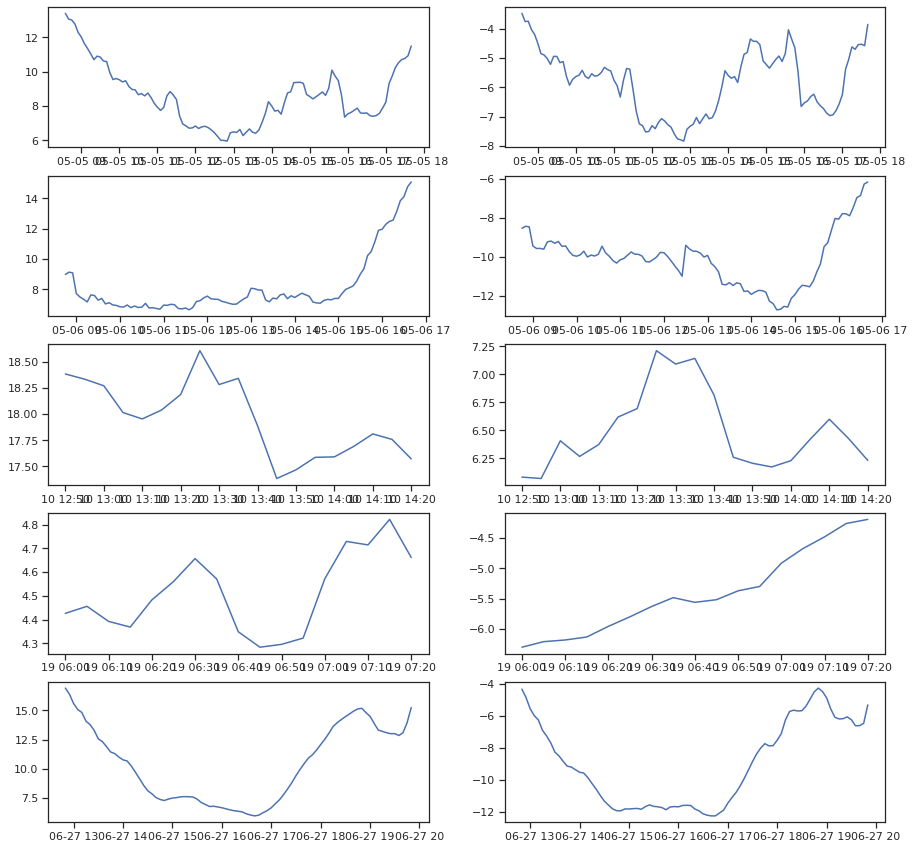

In [16]:
f, axs = plt.subplots(5,2,figsize=(15,15))
ax = 0
for i in [70, 71, 80, 91, 174]:
    axs[ax,0].plot(anom_list[i].P1)
    axs[ax,1].plot(anom_list[i].resid)
    ax += 1

# Anomaly clustering
Собираем датафрейм с признаками аномалий

In [17]:
anomdata = pd.DataFrame(index=[i for i in range(len(anom_list))])

In [18]:
# anomdata['positive'] = [int(np.mean(i.resid) > 0) for i in anom_list]
# anomdata['resid'] = [i.resid.mean() for i in anom_list]
# anomdata['minutes'] = [len(i)*5 for i in anom_list]
anomdata['max_P1'] = [i.P1.max() for i in anom_list]
anomdata['min_P1'] = [i.P1.min() for i in anom_list]
anomdata['min_P2'] = [i.P2.min() for i in anom_list]
anomdata['max_P2'] = [i.P2.max() for i in anom_list]
anomdata['mean_hum'] = [i.humidity.mean() for i in anom_list]
anomdata['change_hum'] = [i.humidity.max()-i.humidity.min() for i in anom_list]
anomdata['mean_temp'] = [i.temperature.mean() for i in anom_list]
anomdata['change_temp'] = [i.temperature.max()-i.temperature.min() for i in anom_list]
anomdata['cloud'] = [int(1 in i.is_cloud.values) for i in anom_list]
anomdata['snow'] = [int(1 in i.is_snow.values) for i in anom_list]
anomdata['rain'] = [int(1 in i.is_rain.values) for i in anom_list]
anomdata['prec_amount'] = [i.prec_amount.mean() for i in anom_list]
anomdata['max_w_speed'] = [i.wind_speed.max() for i in anom_list]
anomdata['min_w_speed'] = [i.wind_speed.min() for i in anom_list]
anomdata['w_dir_sin_max'] = [np.max(np.sin(i.wind_direction)) for i in anom_list]
anomdata['w_dir_sin_mix'] = [np.min(np.sin(i.wind_direction)) for i in anom_list]
anomdata['w_dir_cos_max'] = [np.max(np.cos(i.wind_direction)) for i in anom_list]
anomdata['w_dir_cos_min'] = [np.min(np.cos(i.wind_direction)) for i in anom_list]
anomdata['max_resid'] = [np.max(i.resid) for i in anom_list]
anomdata['min_resid'] = [np.min(i.resid) for i in anom_list]

In [19]:
anomdata.head()

,max_P1,min_P1,min_P2,max_P2,mean_hum,change_hum,mean_temp,change_temp,cloud,snow,rain,prec_amount,max_w_speed,min_w_speed,w_dir_sin_max,w_dir_sin_mix,w_dir_cos_max,w_dir_cos_min,max_resid,min_resid
0,5.414762,3.010760,0.711310,3.882333,50.314649,24.73125,6.410166,5.173333,0,0,1,0.0,2.0,2.0,0.408096,-0.801153,0.912939,-0.598460,7.658587,4.213550
1,3.848393,1.831154,0.820714,2.245357,69.908733,7.54000,2.835033,0.461250,0,0,1,0.3,4.0,4.0,-0.801153,-0.801153,-0.598460,-0.598460,-4.252977,-6.069806
2,15.113750,6.920964,1.756667,17.919643,50.456983,13.00375,5.300983,2.843750,0,0,1,0.0,1.0,1.0,0.408096,0.408096,0.912939,0.912939,11.707541,4.178858
3,20.088662,18.363661,5.455357,8.004000,47.832333,9.79375,4.438667,3.845000,0,0,1,0.0,1.0,1.0,0.850904,0.850904,0.525322,0.525322,5.229719,4.122889
4,20.681305,13.683287,3.135000,6.712143,34.368237,11.16625,8.526058,3.440000,0,0,1,0.0,1.0,1.0,-0.999021,-0.999021,-0.044228,-0.044228,8.155629,4.482098


выбираем фичи, по котрым делаем кластеризацию, снижаем размерность с помощью PCA

In [41]:
#sel_columns = ['max_P1', 'min_P1', 'min_P2', 'max_P2', 'mean_hum', 'prec_amount', 'max_w_speed', 'min_w_speed', 'change_hum', 'max_resid', 'min_resid']
sel_columns = ['mean_hum', 'prec_amount', 'max_w_speed', 'min_w_speed', 'change_hum', 'max_resid', 'min_resid']

In [42]:
pca = PCA(n_components=3)
pca.fit(anomdata[sel_columns])
X = pca.transform(anomdata[sel_columns])

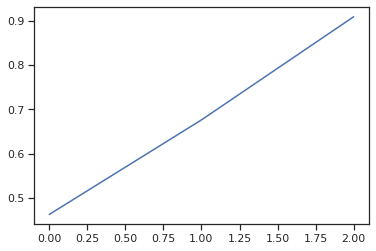

In [43]:
plt.plot(1-pca.explained_variance_ratio_)

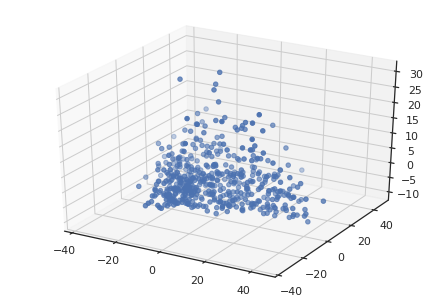

In [44]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0], X[:,1], X[:,2])

определии количество кластеров с помощью  elbow method и silhouette_score

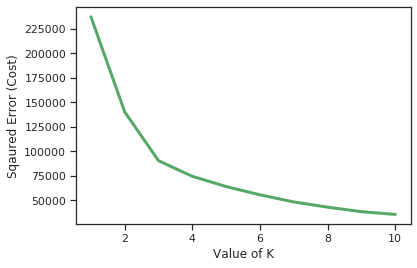

In [45]:
cost =[]
silh = []
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(X) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

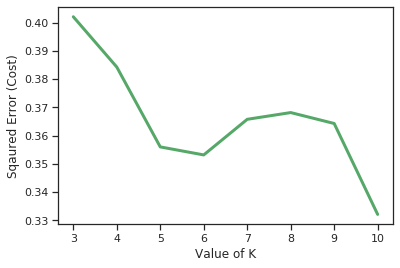

In [46]:
silh = []
for i in range(3, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(X) 
      
    # calculates squared error 
    # for the clustered points 
    silh.append(silhouette_score(X, KM.labels_, random_state=42))
  
# plot the cost against K values 
plt.plot(range(3, 11), silh, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot  

Из сопоставления этих графиков(точки перегиба и максимума) видим , что оптимальное число кластеров 4. Выполняем кластризацию

In [51]:
KM = KMeans(n_clusters = 4, random_state=42)
KM.fit(X)
anomdata['cluster'] = KM.labels_

In [52]:
anomdata.cluster.value_counts()

3    171
1    149
0    109
2     88
Name: cluster, dtype: int64

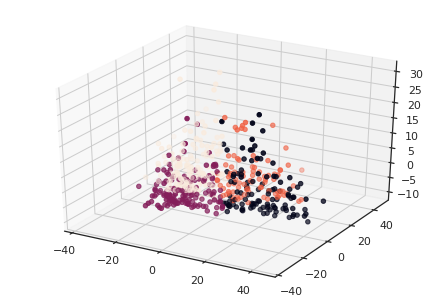

In [53]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:,0], X[:,1], X[:,2], c=anomdata['cluster'].values)

Посмотрим средние значения признаков для каждого кластера

In [54]:
anomdata.groupby(['cluster']).mean()

,max_P1,min_P1,min_P2,max_P2,mean_hum,change_hum,mean_temp,change_temp,cloud,snow,rain,prec_amount,max_w_speed,min_w_speed,w_dir_sin_max,w_dir_sin_mix,w_dir_cos_max,w_dir_cos_min,max_resid,min_resid
cluster,,,,,,,,,,,,,,,,,,,,
0,13.099787,9.092264,4.487977,7.183835,38.094863,9.328255,20.188061,4.131298,0.100917,0.027523,0.908257,0.109675,1.330275,0.871560,0.118360,-0.418299,0.245540,-0.261491,-4.247307,-7.574074
1,18.568976,12.967950,6.698839,9.843688,67.226613,5.619639,10.247478,1.934775,0.281879,0.147651,0.644295,1.204642,1.248322,0.946309,0.102384,-0.385676,0.125642,-0.409821,-5.652730,-10.758384
2,24.344803,18.178836,8.729009,12.911823,44.544428,8.846642,17.365131,3.121202,0.090909,0.011364,0.897727,0.135162,1.136364,0.670455,0.168013,-0.275765,0.340934,-0.097680,9.058134,4.325271
3,37.041068,26.154350,12.743370,19.156778,69.494264,7.330699,11.494645,2.152164,0.245614,0.157895,0.654971,1.198459,1.192982,0.748538,0.147546,-0.381290,0.150641,-0.300282,13.702963,5.411312


Построим распределения минимальной и максимальной концентрации частиц P1 и P2 для каждого кластера

In [55]:
anomalies = anom_list[0]
anomalies['cluster'] = anomdata.cluster.values[0]
for i in range(1, len(anom_list)):
    anom_list[i]['cluster'] = anomdata.cluster.values[i]
    anomalies = anomalies.append(anom_list[i])

In [56]:
anomalies.head()

,P1,P2,pressure,temperature,humidity,temp_meteo,pres_meteo,hum_meteo,wind_direction,wind_speed,...,is_cloud,is_snow,is_rain,dew_point_diff,trend,seasonal,resid,anomaly,gap,cluster
date,,,,,,,,,,,,,,,,,,,,,
2019-04-01 04:45:00,3.166161,1.128571,98883.08250,5.10000,60.49625,6.7,99271.5612,59.0,180.0,2.0,...,0,0,1,6.00000,1.606587,-2.653976,4.213550,True,True,2
2019-04-01 04:50:00,3.153482,1.125714,98890.07500,5.26625,59.96875,6.7,99271.5612,59.0,180.0,2.0,...,0,0,1,6.16625,1.623793,-2.748975,4.278664,True,False,2
2019-04-01 04:55:00,3.279196,1.093571,98890.70125,5.38000,59.57375,6.7,99271.5612,59.0,180.0,2.0,...,0,0,1,6.28000,1.641000,-2.745038,4.383234,True,False,2
2019-04-01 05:00:00,3.249375,1.151786,98895.54875,5.51000,59.08250,6.7,99271.5612,59.0,180.0,2.0,...,0,0,1,6.41000,1.658206,-3.158215,4.749383,True,False,2
2019-04-01 05:05:00,3.406875,1.166071,98900.92500,5.56375,59.21875,6.7,99271.5612,59.0,180.0,2.0,...,0,0,1,6.46375,1.675413,-3.160484,4.891946,True,False,2


Text(0.5, 1.0, 'resid')

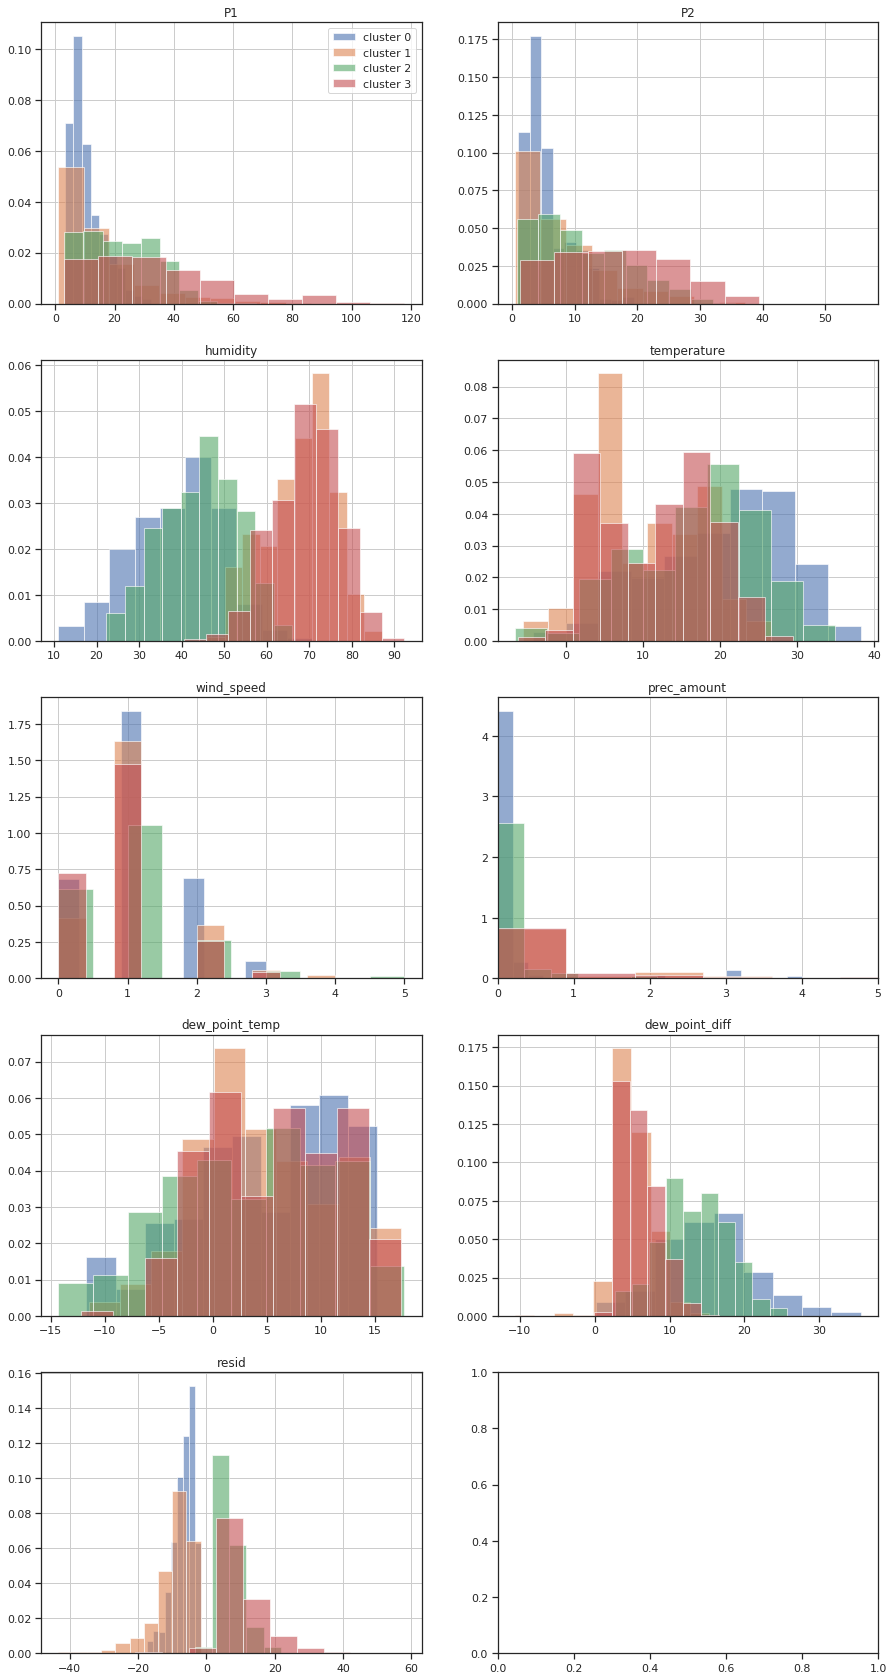

In [59]:
f, axs = plt.subplots(5,2,figsize=(15,30))
n_clast = 4
for i in range(n_clast):
    anomalies[anomalies.cluster == i].P1.hist(ax=axs[0, 0], alpha = 0.6, label=f'cluster {i}', density=True)
axs[0, 0].set_title('P1')
axs[0, 0].legend(loc = 'best')

for i in range(n_clast):
    anomalies[anomalies.cluster == i].P2.hist(ax=axs[0, 1], alpha = 0.6, label=f'cluster {i}', density=True)
axs[0, 1].set_title('P2')

for i in range(n_clast):
    anomalies[anomalies.cluster == i].humidity.hist(ax=axs[1, 0], alpha = 0.6, label=f'cluster {i}', density=True)
axs[1, 0].set_title('humidity')

for i in range(n_clast):
    anomalies[anomalies.cluster == i].temperature.hist(ax=axs[1, 1], alpha = 0.6, label=f'cluster {i}', density=True)
axs[1, 1].set_title('temperature')

for i in range(n_clast):
    anomalies[anomalies.cluster == i].wind_speed.hist(ax=axs[2, 0], alpha = 0.6, label=f'cluster {i}', density=True)
axs[2, 0].set_title('wind_speed')

for i in range(n_clast):
    anomalies[anomalies.cluster == i].prec_amount.hist(ax=axs[2, 1], bins=20, alpha = 0.6, label=f'cluster {i}', density=True)
axs[2, 1].set_title('prec_amount')
axs[2, 1].set_xlim([0, 5])

for i in range(n_clast):
    anomalies[anomalies.cluster == i].dew_point_temp.hist(ax=axs[3, 0], alpha = 0.6, label=f'cluster {i}', density=True)
axs[3, 0].set_title('dew_point_temp')

for i in range(n_clast):
    anomalies[anomalies.cluster == i].dew_point_diff.hist(ax=axs[3, 1], alpha = 0.6, label=f'cluster {i}', density=True)
axs[3, 1].set_title('dew_point_diff')

for i in range(n_clast):
    anomalies[anomalies.cluster == i].resid.hist(ax=axs[4, 0], alpha = 0.6, label=f'cluster {i}', density=True)
axs[4, 0].set_title('resid')

Таким образом, для кластеров 0, 3 характерно низкое значение концентрации частиц, а для 1 и 2 выское. Причем для кластера 1 харакетерно существенное отличие формы распределений P1 и P2.

Так же для кластера 1 характерны высокая влажность, не высокая темпераура, наличие осадков и низкая разность температуры и температуры тоочки росы. Поэтому аномалии из этого кластера можно интерпретировать как завышенные показания датчиков из-за наличия в воздухе капелек воды.

Кластер 2 харатеризуется высокими концентрациями частиц Р1 и Р2 при относительно низкой скорости ветра и небольшом количестве осадков, что позволяет сделать вывод о высокой концентрации пыли в воздухе для аномалий этого типа.

Кластера 0 и 3 характеризуются низкой концентрацией частиц, что обусловлено наличием в этих кластерах отрезков времени с высокой скоростью ветра. Кроме того, в кластере 3 в качестве дополнительного фактора, приводящего к снижению концентрации частиц можно рассматривать наличие высоких значений количества выпавщих осадков.

In [33]:
pca.explained_variance_ratio_

array([0.64921007, 0.17301214, 0.09494439])